## Introduction

We work for `Rusty Bargain`, a vehicle sales service. They want to attract new customers through an application in which you can know the market price of their vehicles (cars). To make this possible, Rusty Bargain have shared with us the record, technical specifications and prices of several vehicles on their database, and we have to use this information to determine the price of new vehicles. 

The main points Rusty Bargain is interested in are:
* The quality of the predictions `(the most accurate predictions posible)`;
* The speed of the predictions `(in the shortest time possible)`;
* The time required to train the model `(in a model trained as fast as possible)`.

## Methodology

To make this possible we will distribute the content as the following:

* Preparing the data
    * Pre-processing
    * Data engineering
* Modeling
    * Sanity test - Linear Regression
    * Random Forest Regressor
    * LightGBM
    * XGBoost
    * CatBoost
* Conclusions

## Preparing the data

Importing the libraries that will be used on the application.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor

Saving the information on a variable `data` to search for discrepancies or "odd" values in each column.

In [2]:
data = pd.read_csv("/datasets/car_data.csv")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
data.describe()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [5]:
data.describe(include='object')

,DateCrawled,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired,DateCreated,LastSeen
count,354369,316879,334536,334664,321474,354369,283215,354369,354369
unique,15470,8,2,250,7,40,2,109,18592
top,05/03/2016 14:25,sedan,manual,golf,petrol,volkswagen,no,03/04/2016 00:00,07/04/2016 07:16
freq,66,91457,268251,29232,216352,77013,247161,13719,654


In [6]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Mileage                  0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

### Filtering data

From the last 4 code blocks above we can make the following changes:
* Changing columns names to a lowercase snake case format may be better.
* Drop duplicated rows.
* We have missing values on columns "VehicleType", "Gearbox", "Model", "FuelType" & "NotRepaired". We shall drop all columns with missing values on those 5 columns and fill the remaining fill another value.
* Columns "DateCrawled", "DateCreated" & "LastSeen" shall be changed to a `datetime` object values columns.
* We have minimum "Price" values of 0. We shall determine a lower threshold.
* We have minimum "RegistrationYear" values of 1000 and maximum values of 9999. We shall determine lower and upper thresholds.
* "RegistrationMonth" value of 0. We shall drop rows with value 0 becuase there is no month 0.
* All values on column "NumberOfPictures" is 0. Column is not relevant.
* "PostalCode" column is not relevant for the predictions.
* We can generate a new date column from information on columns "RegistrationYear" & "RegistrationMonth".

#### Changing column names to lower case / snake case

To make it easier to read the column names let's change them to a combination of lowercase characters and snake case format as the following code blocks.

In [7]:
data.columns = ['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'mileage', 'registration_month', 'fuel_type', 'brand',
       'not_repaired', 'date_created', 'number_of_pictures', 'postal_code',
       'last_seen']
data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'mileage', 'registration_month', 'fuel_type', 'brand',
       'not_repaired', 'date_created', 'number_of_pictures', 'postal_code',
       'last_seen'],
      dtype='object')

#### Dropping duplicates

We need to delete duplicated rows to prevent processing more than once each data entry.

In [8]:
data.drop_duplicates(inplace=True)

#### Deleting `number_of_pictures` column

We saw all cells on this column have value 0, therefore this column is not relevant for future steps of the project. Let's drop it.

In [9]:
data.drop("number_of_pictures", axis=1, inplace=True)

#### Deleting `postal_code` column

Similar to column `number_of_pictures` this column is not relevant to the modeling, but by different reasons. Postal code information refers to the publisher's address, but does not affect the price of the vehicle. We proceed to drop this column as well.

In [10]:
data.drop("postal_code", axis=1, inplace=True)

#### Column `price` filter

We could see the minimum price value we have is 0, meaning this particular vehicle is free. This does not make sense, so we decided to set a lower threshold on this colum on 500 euros and drop all rows below tthis value.

In [11]:
data = data[~(data['price'] < 500)]

#### Column `registration_month` filter

This column has values from 0 to 12. The value 0 does not make sense in the 12 months format we are using, so we proceed to drop all rows with value 0.

In [12]:
data = data[~(data["registration_month"] == 0)]

#### Column `registration_year` filter

Values on this column goes from 1000 to 9999, which indicates us to filter those "odd" values. To make this possible we will set a lower threshold on 1950 and an upper threshold on 2016 and then drop all rows with values out of this range.

In [13]:
data = data[~(data["registration_year"] < 1950) & ~(data["registration_year"] > 2016)]

#### Changing columns data type

To correctly process the remaining information let's change our columns with dates to a datetime format.

In [14]:
data['date_crawled'] = pd.to_datetime(data['date_crawled'], format="%d/%m/%Y %H:%M")
data['date_created'] = pd.to_datetime(data['date_created'], format="%d/%m/%Y %H:%M")
data['last_seen'] = pd.to_datetime(data['last_seen'], format="%d/%m/%Y %H:%M")

#### Dropping rows with a registration date after 04/2016

We can see our latest crawled date on the dataset is from April 7th, 2016, meaning there is no sense on have a registration date after that date. Let's proceed to drop all rows with a month higher than April for the registration year 2016.

In [15]:
data["date_created"].max()

Timestamp('2016-04-07 00:00:00')

In [16]:
data["date_crawled"].max()

Timestamp('2016-04-07 14:36:00')

In [17]:
data = data[~((data["registration_year"] == 2016) & (data["registration_month"] > 5))]

#### Dropping rows with several missing values

We have rows with several missing values on them. Let's drop all rows with 5 column with missing values on them.

In [18]:
data = data[~(data["vehicle_type"].isna() & data["gearbox"].isna() & data["model"].isna() & data["not_repaired"].isna() & data["fuel_type"].isna())]

#### Filling missing values

To finish the data pro-processing let's fill all missing values on our columns with the legend `not_specified`. We can apply this change because all of our columns with missing values have "object" data type.

In [19]:
data["vehicle_type"].fillna("not_specified", inplace=True)
data["gearbox"].fillna("not_specified", inplace=True)
data["model"].fillna("not_specified", inplace=True)
data["fuel_type"].fillna("not_specified", inplace=True)
data["not_repaired"].fillna("not_specified", inplace=True)

### Data engineering

Sometimes there is need that we generate new information using existing information, this can be for various reasons including:
* The new information define better the behavior of the dataset.
* Need to transform the existing data to a new format for future processing.
* Complement the existing information with new information.

In our case, we need to transform the information on columns `date_crawled`, `date_created` & `last_seen` in a way we can use this information to make predictions. To define the price of a vehicle, a date by itself is not as relevant as a difference between dates (this means the lower the difference the less the devaluation of the vehicle in most of the cases). For this reason, let's generate this new column containing this dates difference.

#### Generating new `days_since_registration` column

Before generating this new column let's define the method to use. The first step is to generate a new column called `registration_date` in which we will combine the information from `registration_year` & `registration_month`.

In [20]:
data["registration_date"] = pd.to_datetime(dict(year=data['registration_year'], month=data['registration_month'], day=1))
data.drop(['registration_year', 'registration_month'], axis=1, inplace=True)

Then we need to define the date we will be comparing the `registration_date` column values. We have 3 options:
* date_crawled: date in which the profile was downloaded from database
* date_created: date in which the profile was created
* last_seen: last date the user was active

We will be using `date_crawled` to generate the difference as following, then drop all unnecessary columns.

In [21]:
data["days_since_registration"] = (data["date_crawled"] - data["registration_date"]).dt.days
data.drop(["date_crawled", "date_created", "registration_date", "last_seen"], axis=1, inplace=True)

#### Changing categorical columns to categorical data type

To make possible the use of more sophisticated machine learning algorithms we will change the data type of all object data type columns to categorical data type. Then, reset index to fit new number of rows.

In [22]:
for column in data.columns:
    if data[column].dtype == "object":
        data[column] = data[column].astype("category")

data.reset_index(drop=True, inplace=True)

### Checking the data

Once finishing with our pre-processing and data engineering, check on our resultant information to verify all information is correctly shown.

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279993 entries, 0 to 279992
Data columns (total 10 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   price                    279993 non-null  int64   
 1   vehicle_type             279993 non-null  category
 2   gearbox                  279993 non-null  category
 3   power                    279993 non-null  int64   
 4   model                    279993 non-null  category
 5   mileage                  279993 non-null  int64   
 6   fuel_type                279993 non-null  category
 7   brand                    279993 non-null  category
 8   not_repaired             279993 non-null  category
 9   days_since_registration  279993 non-null  int64   
dtypes: category(6), int64(4)
memory usage: 10.4 MB


In [24]:
data.sample(5)

,price,vehicle_type,gearbox,power,model,mileage,fuel_type,brand,not_repaired,days_since_registration
78828,9999,convertible,manual,163,a4,150000,petrol,audi,not_specified,3525
133916,2200,sedan,manual,75,golf,150000,petrol,volkswagen,no,5027
158014,10500,small,manual,174,cooper,125000,petrol,mini,no,2253
243224,1550,small,manual,50,lupo,100000,petrol,volkswagen,no,5724
208365,1350,small,manual,75,2_reihe,150000,petrol,peugeot,no,5517


### Conclusions

We need to look carefully and understand the information we have to look up for:
* Missing information
* Discrepancies
* Incorrect data types
* Odd values on the columns
* Unnecessary information

By doing this we can apply an addecuate pre-processing and assure the following:
* Working with the best data possible
* Discard input data errors
* Generate new information if needed
* Process the information the best way possible for future steps

## Model training

Our next step is continue to modeling various machine learning algorithms and test their accuracy and processing time one to another. This will give us a better insight about the capabilities and limits of each algorithm. This will be done this way:
* Sanity test
    * Linear Regression
* Predictive models
    * Random Forest Regressor
    * LightGBM
    * XGBoost
    * CatBoost
    
The loss function for the gradient boost models will be RMSE.

### Defining features and target

Let's define which columns of our dataset will be our features and which columns will be our targets. For this case will be as following:
* Features
    * vehicle_type
    * gearbox
    * power
    * model
    * mileage
    * fuel_type
    * brand
    * not_repaired
    * days_since_registration
* Target
    * price
    
Let's save this information on the following variables:
* Features: `X`
* Target: `y`

In [25]:
X = data.drop(['price'], axis=1)
y = data['price']

Now we need to generate 2 lists with the column names for numeric variables and categorical variables.

In [26]:
numerics = X.select_dtypes(include=['int64']).columns
categorical = X.select_dtypes(include=['category']).columns

The last step if this point is standarize the numeric values of our features.

In [27]:
scaler = StandardScaler()
X[numerics] = scaler.fit_transform(X[numerics])

In [28]:
del data

### Sanity test - Linear Regression

We will be using the Linear Regression model from Scikit-Learn module to apply a sanity test. Most of times Linear Regression model is not enough to get the best results, but it can be used as a reference point in which we can compare it to other models and test their accuracy.

To make this possible we need to apply an OHE encoding on all our categorical columns as following:

In [29]:
X_lr = pd.get_dummies(X, drop_first=True)

Then we split our features and target on a relation 70/30 for training/test sets:

In [30]:
X_train, X_test, y_train, y_test = tts(X_lr, y, test_size=0.3, random_state=0)

Now we proceed to train our model and save the training processing time:

In [31]:
model_lr = LinearRegression()
start_train = datetime.now()
model_lr.fit(X_train, y_train)
stop_train = datetime.now()
train_time = stop_train - start_train

Then we predict new target values and evaluate the prediction processing time:

In [32]:
start_pred = datetime.now()
y_pred = model_lr.predict(X_test)
stop_pred = datetime.now()
pred_time = stop_pred - start_pred

Lastly, we obtain the RMSE score, $R^{2}$ score and execution times.

In [33]:
rmse = mse(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}.")
print(f"R2: {r2}.")
print(f"Training time: {train_time}.")
print(f"Prediction time: {pred_time}.")

RMSE: 2771.599205048633.
R2: 0.6380002498673689.
Training time: 0:00:15.636077.
Prediction time: 0:00:00.184401.


We can see the $R^{2}$ score is not as high as we wanted, but is a good reference point for future models comparison.

In [34]:
del X_lr, model_lr

### Random Forest Regressor

The first model we will be evaluating is the Random Forest Regressor. This machine learning model is not as sophisticated as others and is probable to have overfitting in the model, but commonly have higher $R^{2}$ scores due to its robust tree ensemble.

The categorical features will be encoded using the Ordinal Encoder for the information to be read the ebst way possible for the model.

In [35]:
encoder = OrdinalEncoder()
X_rfr = encoder.fit_transform(X)

Splitting our features and target in the same relation 70/30:

In [36]:
X_train, X_test, y_train, y_test = tts(X_rfr, y, test_size=0.3, random_state=0)

Training model and getting training processing time:

In [37]:
model_rfr = RandomForestRegressor(n_estimators=100, random_state=0)
start_train = datetime.now()
model_rfr.fit(X_train, y_train)
stop_train = datetime.now()
train_time = stop_train - start_train

Obtaining predictions and getting prediction processing time:

In [38]:
start_pred = datetime.now()
y_pred = model_rfr.predict(X_test)
stop_pred = datetime.now()
pred_time = stop_pred - start_pred

Printing the RMSE score, $R^{2}$ score and execution times.

In [39]:
rmse = mse(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}.")
print(f"R2: {r2}.")
print(f"Training time: {train_time}.")
print(f"Prediction time: {pred_time}.")

RMSE: 1599.9493884269632.
R2: 0.8793687288992978.
Training time: 0:01:38.786309.
Prediction time: 0:00:04.220232.


We can see the $R^{2}$ score is higher compared to the Linear Regression model, but the training and prediction times have increased also. This may indicate there would be better model options.

In [40]:
del X_rfr, model_rfr

### LightGBM

LightGBM is a gradient boosting framework that uses tree based learning algorithms that grows trees leaf-wise, this means it will choose the leaf with max delta loss to grow.

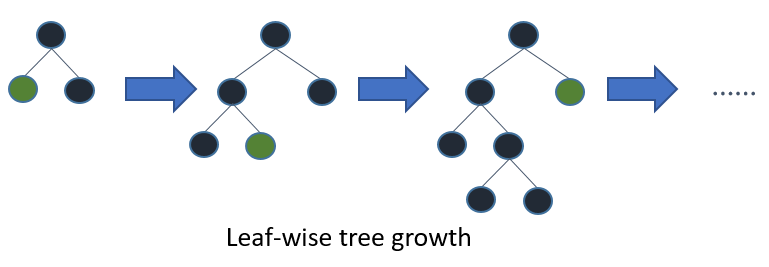

To work with this model we are going to split our features and target in a relation 70/30 for train/test sets (this sets will also be used for XGBoost and CatBoost).

In [41]:
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.3, random_state=0)

LightGBM needs us to define our train set using the method `Dataset`, in which we introduce our train set and define which columns are wanted to be processed as categorical features.

In [42]:
lgb_train = lgb.Dataset(X_train, label=y_train, categorical_feature=list(categorical))

LightGBM also needs to define a dictionary containing the parameters for its configuration. For our case the three most important parameters are:
* `boosting`: Defined as `'gbdt'` to apply the Gradient Boosting Decision Tree algorithm.
* `objective`: Defined as `'regression'` to apply a regresion algorithm.
* `metric`: Defined as `'rmse'` to evaluate the rmse value on the modeling.

Remaining parameters can be configured as needed.

In [43]:
lgbm_params = {'learning_rate': 0.05, 
               'boosting': 'gbdt',
               'objective': 'regression',
               'metric': 'rmse',
               'num_leaves': 100,
               'max_depth': 10,
               'seed': 0}

Training model using training set and parameters and getting training processing time:

In [44]:
start_train = datetime.now()
model_lgbm = lgb.train(lgbm_params, lgb_train, 50)
stop_train = datetime.now()
train_time = stop_train - start_train

/opt/conda/envs/python3/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.081752 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 835
[LightGBM] [Info] Number of data points in the train set: 195995, number of used features: 9
[LightGBM] [Info] Start training from score 5141.141080


Obtaining predictions and getting prediction processing time:

In [45]:
start_pred = datetime.now()
y_pred = model_lgbm.predict(X_test)
stop_pred = datetime.now()
pred_time = stop_pred - start_pred

Printing the RMSE score, $R^{2}$ score and execution times.

In [46]:
rmse = mse(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}.")
print(f"R2: {r2}.")
print(f"Training time: {train_time}.")
print(f"Prediction time: {pred_time}.")

RMSE: 1741.6752406358337.
R2: 0.8570507863712131.
Training time: 0:00:03.503523.
Prediction time: 0:00:00.692402.


We can see that using LightGBM we can obtain results quite similar to the ones obtained by the Random Forest Regressor in less time (and by a lot). This is obtained due to the gradient boosting method, but the use of this model shall be considered before hand.

In [47]:
del lgb_train, lgbm_params, model_lgbm

### XGBoost

XGBoost stands for “Extreme Gradient Boosting” and the model choice slected is the `decision tree ensembles`. The tree ensemble model consists of a set of classification and regression trees (CART) which sums the prediction of multiple trees together.

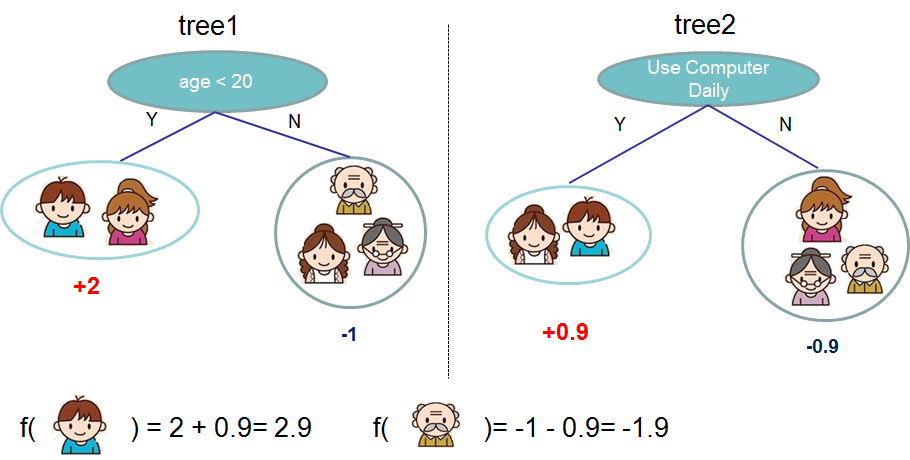

Similar to LightGBM, XGBoost also needs to save the training set using the method `DMatrix`, and also needs us to specify the use of categorical features by parameter `enable_categorical`. This parameter started  to appear since version 1.5 of this library.

In [48]:
xgb_train = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)

As well as in LightGBM, XGBoost needs a dictionary in which save the parameters to be used in the model. The principal parameters for our case are:
* `objective`: Configured as "reg:squarederror" to set a regression with squared loss.
* `eval_metric`: Configured as "rmse" to apply a RMSE metric to the training and prediction.

The remaining parameters can be configured as needed.

In [49]:
xgb_params = {'max_depth': 10,
              'objective': 'reg:squarederror',
              'eval_metric': 'rmse',
              'learning_rate': 0.05,
              'seed': 0}

Training model using training set and parameters and getting training processing time:

In [50]:
start_train = datetime.now()
model_xgbm = xgb.train(xgb_params, xgb_train, 50)
stop_train = datetime.now()
train_time = stop_train - start_train

Obtaining predictions (using a features test set the same way as the training set) and getting prediction processing time:

In [51]:
start_pred = datetime.now()
xgb_test = xgb.DMatrix(X_test, enable_categorical=True)
y_pred = model_xgbm.predict(xgb_test)
stop_pred = datetime.now()
pred_time = stop_pred - start_pred

Printing the RMSE score, $R^{2}$ score and execution times.

In [52]:
rmse = mse(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}.")
print(f"R2: {r2}.")
print(f"Training time: {train_time}.")
print(f"Prediction time: {pred_time}.")

RMSE: 1775.7706566554084.
R2: 0.8513991939424169.
Training time: 0:00:30.062509.
Prediction time: 0:00:00.418159.


This model can obtain results as good as the ones in the Random Forest Regressor model in a reduced time compared to the Random Forest model. In this particular configuration the RMSE and $R^{2}$ scores lower than the scores on LightGBM model, but this probably can be fixed with a better configuration.

In [53]:
del xgb_train, xgb_params, model_xgbm, xgb_test

### CatBoost

CatBoost is a model based on gradient boosted decision trees. During training, a set of decision trees is built consecutively. Each successive tree is built with reduced loss compared to the previous trees.

To make this possible we use the CatBoostRegressor model and configure it with the `loss_function` parameter as "RMSE".

In [54]:
model_cat = CatBoostRegressor(iterations=100, learning_rate=0.1, loss_function="RMSE", random_seed=0)

We train the model using the training set, in which we can define the columns that shall be processed as categorical features and the progress information output from the training at the same time we get the training processing time.

In [55]:
start_train = datetime.now()
model_cat.fit(X_train, y_train, cat_features=list(categorical), verbose=10)
stop_train = datetime.now()
train_time = stop_train - start_train

0:	learn: 4308.5440848	total: 243ms	remaining: 24s
10:	learn: 2714.0420062	total: 1.99s	remaining: 16.1s
20:	learn: 2203.7169399	total: 3.69s	remaining: 13.9s
30:	learn: 2011.9697959	total: 5.38s	remaining: 12s
40:	learn: 1935.1327813	total: 7.07s	remaining: 10.2s
50:	learn: 1891.7245930	total: 8.77s	remaining: 8.42s
60:	learn: 1860.6949227	total: 10.4s	remaining: 6.68s
70:	learn: 1836.4251200	total: 12.1s	remaining: 4.95s
80:	learn: 1820.1376024	total: 13.8s	remaining: 3.23s
90:	learn: 1802.8743513	total: 15.5s	remaining: 1.53s
99:	learn: 1784.7645613	total: 17.1s	remaining: 0us


Obtaining predictions and getting prediction processing time:

In [56]:
start_pred = datetime.now()
y_pred = model_cat.predict(X_test)
stop_pred = datetime.now()
pred_time = stop_pred - start_pred

Printing the RMSE score, $R^{2}$ score and execution times.

In [57]:
rmse = mse(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}.")
print(f"R2: {r2}.")
print(f"Training time: {train_time}.")
print(f"Prediction time: {pred_time}.")

RMSE: 1801.7260221644888.
R2: 0.8470234308295754.
Training time: 0:00:17.613183.
Prediction time: 0:00:00.104664.


This model has the lowest RMSE and $R^{2}$ scores among all the tree based models, but has the lowest prediction time with a moderate training time.

In [58]:
del model_cat

### Conclusions

From the application of all the previous models, we can obtain the following table with the following values:

| --- | Linear Regression | Random Forest Regressor | LightGBM | XGBoost | CatBoost |
| -- | --- | --- | --- | --- | --- |
| RMSE | 2771.59 | 1599.94 | 1741.67 | 1775.77 | 1801.72 |
| $R^{2}$ score | 0.6380 | 0.8793 | 0.8570 | 0.8513 | 0.8470 |
| Training time | 15.25 s | 111.61 s | 3.18 s | 30.74 s | 17.37 s |
| Prediction time | 00.14 s | 04.28 s | 00.69 s | 0.43 s | 00.1 s |

## General conclusions

After completing this project, the conclusions are:

* When you want to use a machine learning algorithm you shall keep in mind how the algorithm you will use process the information. This will indicate you how you should pre-process the information on the dataset and transform the information as needed.
* Depending on your necesities is the algorithm you shall use. All of them have advantages and disadvantages that shall be considered before decide to use them. 
* Be careful of the processing time of all the models. Most of times, a more robust model require more time on its training and its predictions (as the Random Forest model), but models with lower processing times (as LightGBM) may not be the best option depending the case.